## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [6]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

import models_mae

### Define utils

In [13]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16', **kwargs):
    # build model
    model = getattr(models_mae, arch)(**kwargs)
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model, patch_size, channels=3):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y, p=patch_size, c=channels)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask, p=patch_size, c=channels)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

### Load an image

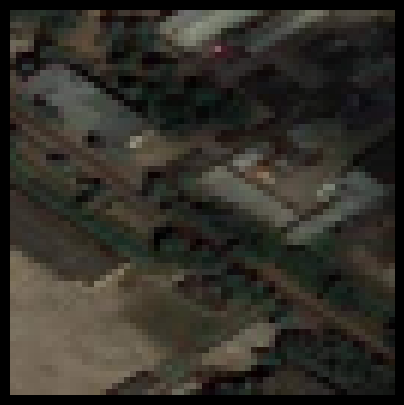

In [8]:
img_size = 64

# load an image
img_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRFQsDBSqgPKLHyunyQ0LJVDBXwzpnvWJqAOLPvVaUoA0xP-ZH4PPVCuyZtMllgEHSRTog&usqp=CAU' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(requests.get(img_url, stream=True).raw)

img = img.resize((img_size, img_size))
img = np.array(img) / 255.

assert img.shape == (img_size, img_size, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Load a pre-trained MAE model

In [11]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)
attention = 'scaled_dot_product'
patch_size = 8
ffn_name = "FusedMLP"


# download checkpoint if not exist
# checkpoint_basedir = "/data2/HDD_16TB/ICCV/Model_Saving"
checkpoint_basedir = "."

checkpoint_dir = os.path.join(checkpoint_basedir, f"out_i{img_size}_p{patch_size}_b64_e200_{attention}")

checkpoint_name = "checkpoint-0.pth"

chkpt_path = os.path.join(checkpoint_dir, checkpoint_name)
model_mae = prepare_model(chkpt_path, 'mae_vit_large_patch16', img_size=img_size, patch_size=patch_size, attention=attention, ffn_name="FusedMLP")
print('Model loaded.')


Using xformers
<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with pixel reconstruction:


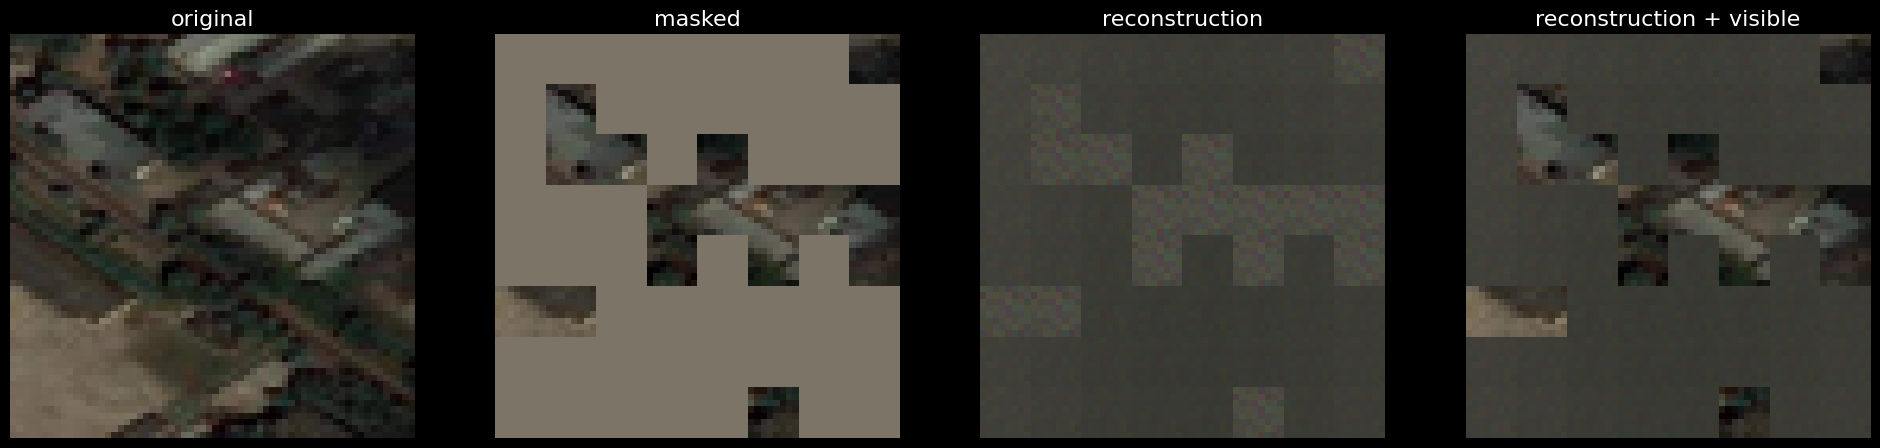

In [15]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae, patch_size=patch_size)